In [1]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt
import copy
import torch
#%matplotlib notebook  


In [76]:
#img_path = "/srv/data/hamin/OCR/doc_unet/original/1_1.jpg"

#img_path = "../OCR_data/doc_unet/original/1_1.jpg"
img_path = "./receipt_images/002_colored_again.jpg"

image = cv2.imread(img_path)


In [77]:
image.shape

(3024, 4032, 3)

In [78]:
image = image.copy()

height, width, channels = image.shape
gray = cv2.cvtColor(copy.deepcopy(image), cv2.COLOR_BGR2GRAY)
image_size = gray.size


In [79]:
threshold = blur_and_threshold(gray)
edges = cv2.Canny(threshold, 50, 50, apertureSize=3)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
simplified_contours = []

for cnt in contours:
    hull = cv2.convexHull(cnt)
    simplified_contours.append(cv2.approxPolyDP(hull,
                                                0.001 * cv2.arcLength(hull, True), True))
#simplified_contours = np.array(simplified_contours)

In [81]:
biggest_n, approx_contour = biggest_contour(simplified_contours, image_size)

In [82]:
#threshold = cv2.drawContours(image, simplified_contours, biggest_n, (0, 255, 0), 10)


In [83]:
threshold = cv2.fillPoly(copy.deepcopy(image), pts=[np.int32((simplified_contours[biggest_n]))], color=(255,255,255))

#threshold

msk = np.zeros(threshold.shape)

lower_brown = np.array([255,255,255])
upper_brown = np.array([(255,255,255)])
msk = cv2.inRange(threshold, lower_brown, upper_brown)

# msk[threshold == [255, 255, 255]] = 1
# msk[msk != [1,1,1]] = 0

# msk = cv2.inRange(msk, np.array([1,1,1]), np.array([1,1,1]))

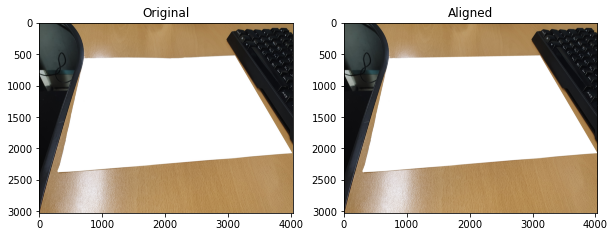

In [84]:
f, axarr = plt.subplots(1,2, figsize=(10,7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
threshold = cv2.cvtColor(threshold, cv2.COLOR_BGR2RGB)
axarr[0].imshow(image)
axarr[0].title.set_text('Original')

axarr[1].imshow(threshold)
axarr[1].title.set_text('Aligned')

In [73]:
# threshold = cv2.cvtColor(threshold, cv2.COLOR_RGB2BGR)
# cv2.imwrite("./receipt_images/002_colored.jpg", threshold)

True

In [16]:
# #threshold

# msk = np.zeros(threshold.shape)

# msk[threshold == (0, 255, 0)] = 1

In [17]:
np.where(msk != [0,0,0])

(array([   0,    0,    0, ..., 4031, 4031, 4031]),
 array([   4,    9,   43, ..., 2990, 3020, 3020]),
 array([2, 2, 0, ..., 0, 0, 2]))

<IPython.core.display.Javascript object>


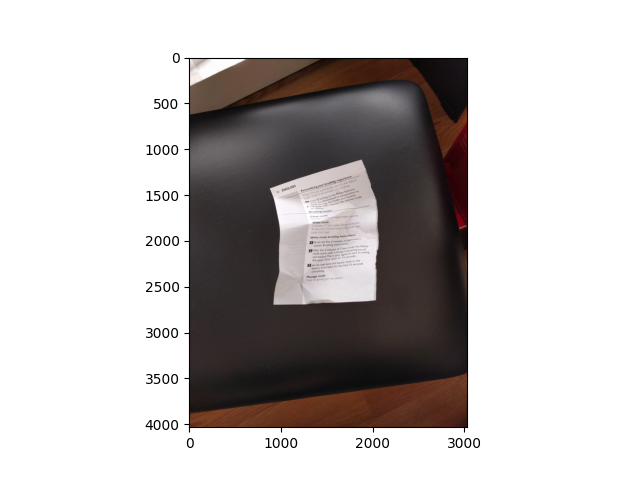

In [27]:
plt.imshow(msk)

In [217]:
msk = get_mask(image)

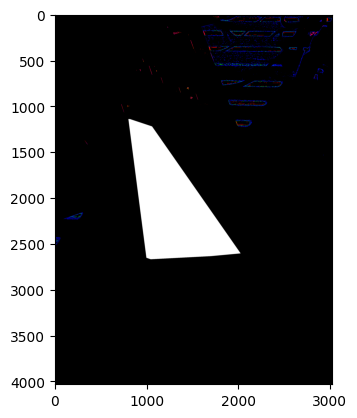

In [218]:
plt.imshow(msk)

In [5]:
import numpy as np
import cv2
import re
from matplotlib import pyplot as plt


# ## **Use Gaussian Blurring combined with Adaptive Threshold**

def blur_and_threshold(gray):
    gray = cv2.GaussianBlur(gray, (3, 3), 2)
    threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold = cv2.fastNlMeansDenoising(threshold, 11, 31, 9)
    return threshold


# ## **Find the Biggest Contour**

# **Note: We made sure the minimum contour is bigger than 1/10 size of the whole picture. This helps in removing very small contours (noise) from our dataset**


def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


# # Transformation the image

# **1. Convert the image to grayscale**

# **2. Remove noise and smoothen out the image by applying blurring and thresholding techniques**

# **3. Use Canny Edge Detection to find the edges**

# **4. Find the biggest contour and crop it out**


def transformation(image):
    image = image.copy()

    height, width, channels = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_size = gray.size

    threshold = blur_and_threshold(gray)
    # We need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal
    # are sure to be edges and those below minVal are sure to be non-edges, so discarded.
    #  Those who lie between these two thresholds are classified edges or non-edges based on their connectivity.
    # If they are connected to "sure-edge" pixels, they are considered to be part of edges.
    #  Otherwise, they are also discarded
    edges = cv2.Canny(threshold, 50, 150, apertureSize=7)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    simplified_contours = []

    for cnt in contours:
        hull = cv2.convexHull(cnt)
        simplified_contours.append(cv2.approxPolyDP(hull,
                                                    0.001 * cv2.arcLength(hull, True), True))
    simplified_contours = np.array(simplified_contours)
    biggest_n, approx_contour = biggest_contour(simplified_contours, image_size)

    threshold = cv2.drawContours(image, simplified_contours, biggest_n, (0, 255, 0), 1)

    dst = 0
    if approx_contour is not None and len(approx_contour) == 4:
        approx_contour = np.float32(approx_contour)
        dst = four_point_transform(threshold, approx_contour)
    croppedImage = dst
    return croppedImage


# **Increase the brightness of the image by playing with the "V" value (from HSV)**

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


# **Sharpen the image using Kernel Sharpening Technique**


def final_image(rotated):
    # Create our shapening kernel, it must equal to one eventually
    kernel_sharpening = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    # applying the sharpening kernel to the input image & displaying it.
    sharpened = cv2.filter2D(rotated, -1, kernel_sharpening)
    sharpened = increase_brightness(sharpened, 30)
    return sharpened


# ## 1. Pass the image through the transformation function to crop out the biggest contour

# ## 2. Brighten & Sharpen the image to get a final cleaned image
#cv2.imwrite(path + "Final_Image2.jpg", cleaned_image)